# small data로 training code 확인해보기

In [1]:
import pandas as pd
df = pd.read_csv('trocr/testdata/cropped_image.csv')
df

,original_img_name,text,bbox,높이에 대한 너비 비,text_length,file_name
0,medicine_31215.jpg,건강,"[270.7996407778658, 181.6060866848643, 85.8899...",1.729167,2,medicine_31215_0.jpg
1,medicine_31215.jpg,기능식품,"[231.2671741729349, 237.28789101405005, 163.89...",3.250000,4,medicine_31215_1.jpg
2,medicine_31215.jpg,MADE,"[2084.202921282695, 176.46746671166335, 243.71...",3.909091,4,medicine_31215_2.jpg
3,medicine_31215.jpg,IN,"[2334.8476798738207, 183.39483441141803, 98.24...",1.677419,2,medicine_31215_3.jpg
4,medicine_31215.jpg,USA,"[2444.426041669941, 185.91387721132884, 150.51...",2.366337,3,medicine_31215_4.jpg
5,medicine_31215.jpg,Alive!,"[741.6678587962095, 333.80412782543954, 1329.4...",1.881068,6,medicine_31215_5.jpg
6,medicine_31215.jpg,얼라이브!,"[877.3582427556327, 2099.3634109458117, 473.36...",3.402976,5,medicine_31215_6.jpg
7,medicine_31215.jpg,원스데일리,"[1388.408311468296, 2103.4166606571503, 554.70...",3.937500,5,medicine_31215_7.jpg
8,medicine_31215.jpg,50+,"[1009.8018631112581, 2280.770511880879, 357.22...",2.236220,3,medicine_31215_8.jpg
9,medicine_31215.jpg,세트,"[1413.5648861099594, 2278.2548544167125, 366.0...",2.049296,2,medicine_31215_9.jpg


In [2]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=32): # max_target_length 낮출 필요 있음.max(df['text length']) 찍어보기
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [4]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
train_dataset = IAMDataset(root_dir='trocr/testdata/croppedimages/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='trocr/testdata/croppedimages/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 20
Number of validation examples: 6


In [6]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


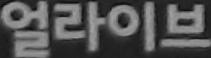

In [7]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [8]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

라이


In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

# train model

In [11]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-printed')
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [12]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
!pip install datasets jiwer

In [13]:
from datasets import load_metric
cer_metric = load_metric("cer")

/tmp/ipykernel_63639/1679503157.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# def compute_metrics(pred):
#     labels_ids = pred.label_ids
#     pred_ids = pred.predictions

#     pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
#     label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
#     pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
#     label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

#     cer = cer_metric.compute(predictions=pred_str, references=label_str)
#     wer = wer_metric.compute(predictions=pred_str, references=label_str)

#     return {"cer": cer, "wer": wer}

In [14]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [15]:
from transformers import AdamW
from tqdm.notebook import tqdm
import csv

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(1):  # loop over the dataset multiple times
   # train
  model.train()
  train_loss = 0.0
  for batch in tqdm(train_dataloader):
    # get the inputs
    for k,v in batch.items():
      batch[k] = v.to(device)

    # forward + backward + optimize
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()

  print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
  model.eval()
  valid_cer = 0.0
  with torch.no_grad():
    for batch in tqdm(eval_dataloader):
      # run batch generation
      outputs = model.generate(batch["pixel_values"].to(device))
      # compute metrics
      cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
      valid_cer += cer

  print("Validation CER:", valid_cer / len(eval_dataloader))


  with open('result.csv', 'a') as f:
    data = [{'epoch': epoch, 'loss': train_loss/len(train_dataloader), 'Validation CER':  valid_cer / len(eval_dataloader) }]
    writer = csv.DictWriter(f, fieldnames=data[0].keys()) # fieldnames=['Name', 'Height']
    if epoch == 0:
        writer.writeheader()  # 첫 번째 루프에서만 헤더 쓰기
    writer.writerows(data)

  model.save_pretrained("./model/")

/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Loss after epoch 0: 10.322248458862305


  0%|          | 0/2 [00:00<?, ?it/s]

/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 1.05


# Inference

In [ ]:
df2 = pd.read_json(r'/content/drive/MyDrive/trocr/data/label/TL1/result/medicine/annotations/medicine_00002.json')
df_2row = df2.iloc[0]
df_2row


In [ ]:

for i, j in zip(df_2row['annotations']['polygons'], df_2row['annotations']["bbox"]):
    print(i['text'], j)

for i in  df_2row['annotations']["bbox"]:
    print(i['x'],i['x']+i['width'], i['y'],i['y']+i['height'])

from PIL import Image

image1 = Image.open(r'/content/drive/MyDrive/trocr/data/image/TS1/result/medicine/image/medicine_00002.jpg')
image1.show()

cnt=0

import os
data = {'file_name' : [], 'text' : []}

# 이미지 자르기 crop함수 이용 ex. crop(left,up, rigth, down)
for i,j in  zip(df_2row['annotations']["bbox"],df_2row['annotations']['polygons']):
    croppedImage=image1.crop((i['x'],i['y'], i['x']+i['width'],i['y']+i['height']))
    croppedImage.show()

    print("잘려진 사진 크기 :",croppedImage.size)
    croppedImage.save('./inferenceresult/croppedImage{}.jpg'.format(cnt))
    data['file_name'].append('croppedImage{}.jpg'.format(cnt))
    data['text'].append(j['text'])
    cnt += 1

df = pd.DataFrame(data)
df

In [ ]:
# sample_test_df = pd.read_csv('/content/data/test.csv')
# sample_test_df.drop(['id'],axis=1,inplace=True)
df.file_name=df.file_name.apply(lambda x: './inferenceresult/'+ x )


In [ ]:
# 저장된 모델 불러오기
# from transformers import VisionEncoderDecoderModel, AutoTokenizer
# model=VisionEncoderDecoderModel.from_pretrained('./model')
# tokenizer=AutoTokenizer.from_pretrained('./model')

In [ ]:
from tqdm.auto import tqdm
img_names, outputs= [], []
# device=torch.device('cuda')
# model.to(device)

for i in tqdm(range(1)):
    image = Image.open(df['file_name'][i]).convert('RGB')
    # pixel_values =(processor(image,return_tensors='pt').pixel_values).to(device)
    pixel_values =processor(image,return_tensors='pt').pixel_values
    
    generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    img_names.append(df.file_name[i])
    outputs.append(generated_text)
    print('Decoded label = {},{}'.format(img_names[i],generated_text))

#img_idx = np.random.randint(len(eval_dataaset))
#image = Image.open(eval_dataset.dataset_dir + train_df['file_name'][img_idx])

In [ ]:
df = pd.DataFrame({'image_names':img_names, 'outputs':outputs})
sub=pd.read_csv('/content/data/sample_submission.csv')
sub['label']=df.outputs
# sub.to_csv('trocr_submit.csv',index=False)